In [1232]:
# --------------  We start with data formating --------------

import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



# Load the data from the CSV file
df = pd.read_csv('stock_data_AMEN.csv')

# Keep only the "Date" and "Close" columns to limit the amount of data we feed the model
df = df[['Date', 'Volume']]

# Assuming 'Date' is in datetime format, if not, convert it first
df['Date'] = pd.to_datetime(df['Date'])

# Filter training data (6 last months of 2018)
start_date = '2018-06-01'
end_date = '2018-12-31'
train_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Choose the slicing window
N = 5 

# Calculate the index to start the test data (N indices before the end date)
test_start_index = len(df[df['Date'] <= end_date]) - N
test_end_date = '2019-03-01'
test_end_index = len(df[df['Date'] <= test_end_date])

# Filter test data (first 2 months of 2019)
test_data = df.iloc[test_start_index:test_end_index+1]

#  ------- We normalize the data to help the NN converge :

# Initialize separate scalers for training and test data
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

train_data['Volume'] = scaler_train.fit_transform(train_data[['Volume']])
test_data['Volume'] = scaler_test.fit_transform(test_data[['Volume']])


# ------- We now format the train data into Input-Output Pairs :

input_sequences = []
targets = []

# Corrected data slicing for input-output pairs
for i in range(len(train_data) - N):
    input_sequence = train_data['Volume'].iloc[i:i+N].values
    target = train_data['Volume'].iloc[i+N]
    input_sequences.append(input_sequence)
    targets.append(target)
    

# Convert data into tensors:
input_tensors = torch.tensor(input_sequences, dtype=torch.float32)
target_tensors = torch.tensor(targets, dtype=torch.float32)


# Create input sequences for the test data and convert them into tensor
test_input_sequences = []

for i in range(len(test_data) - N):
    input_sequence = test_data['Volume'].iloc[i:i+N].values
    test_input_sequences.append(input_sequence)
    
test_input_tensors = torch.tensor(test_input_sequences, dtype=torch.float32)


/var/folders/w9/mnqyw1151sb3m7h0pdr46lz00000gn/T/ipykernel_24445/1563611444.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Volume'] = scaler_train.fit_transform(train_data[['Volume']])
/var/folders/w9/mnqyw1151sb3m7h0pdr46lz00000gn/T/ipykernel_24445/1563611444.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Volume'] = scaler_test.fit_transform(test_data[['Volume']])


In [1233]:
# --------------  We create the NN model --------------

input_dim = N              # N = 30
hidden_dim = 60             # To be changed for better performances
output_dim = 1              # Forecasted price

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_5 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.layer_2(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_2(x))
        x = self.layer_3(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_3(x))
        x = self.layer_4(x)  # Use linear activation
        x = torch.nn.functional.relu(self.layer_4(x))
        x = self.layer_5(x)  # Use linear activation
        
        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)



In [1234]:
#choosing the optimizer and the learning rate
learning_rate = 0.00005                                                   # Smaller learning rate to assure convergence 
loss_fn = nn.MSELoss()  # Use L1Loss for MAE

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      # Use an advanced optimizer like Adam



In [1235]:
# ---------------------- Now we train the model ------------
batch_size = 2
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    print(epoch)
    
    for i in range(0, len(input_tensors), batch_size):
        inputs = input_tensors[i:i+batch_size]
        targets = target_tensors[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, targets)


        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()
        
    # Append the loss value for the current epoch
    loss_values.append(loss.item())
    
print("Training Complete")
print(len(targets))


0


/Users/thedog/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Training Complete
2


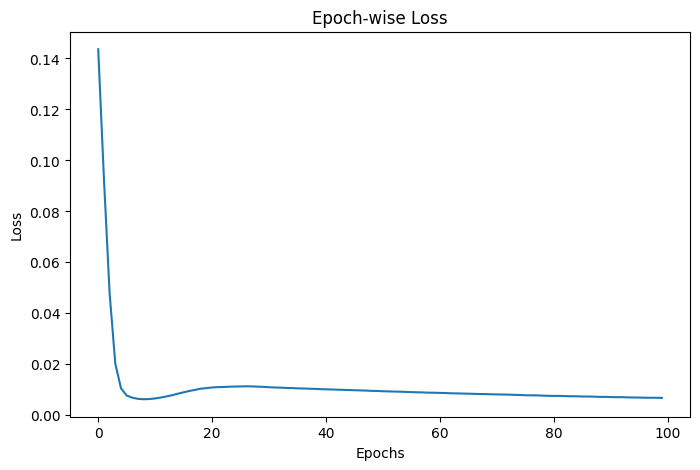

0.0068161641247570515


In [1236]:
# Generate step values based on the number of epochs
step = np.arange(num_epochs)

# Your existing code for plotting
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(step, np.array(loss_values))
plt.title("Epoch-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
print(loss_values[-1])

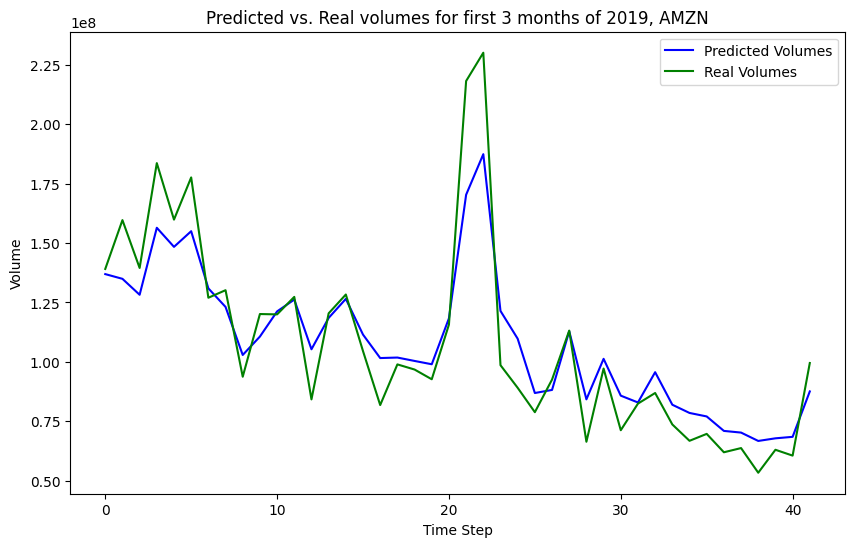

In [1239]:

# -------------------- Now let's test our model on the first 2 months of 2019 

# Set the model in evaluation mode
model.eval()

# Create an empty list to store the model's predictions
test_predictions = []

# Iterate through the test input sequences
for input_sequence in test_input_tensors:
    # Perform inference
    with torch.no_grad():
        prediction = model(input_sequence)
    
    # Append the prediction to the list
    test_predictions.append(prediction.item())

# Convert the list of predictions to its original scale
test_predictions = scaler_test.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Retrieve the real prices for 2019-2020
real_data = df[(df['Date'] >= end_date) & (df['Date'] <= test_end_date)]

# Plot the predicted prices, real prices
step = np.arange(len(test_predictions))

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(step, test_predictions, label="Predicted Volumes", color="blue")
plt.plot(step, real_data['Volume'].values, label="Real Volumes", color="green")
plt.title("Predicted vs. Real volumes for first 3 months of 2019, AMZN")
plt.xlabel("Time Step")
plt.ylabel("Volume")
plt.legend()
plt.show()


In [1238]:
# Calculate the MSE for firdst two months
mse_2019 = mean_squared_error(real_data['Volume'].values, test_predictions)
print("Mean Squared Error (MSE) for 2019 predictions: {:.4e}".format(mse_2019))


Mean Squared Error (MSE) for 2019 predictions: 2.3563e+14
